In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

import symmetric_methods as sm


In [3]:
L=10

dim = np.zeros((L+1,))

dim[0] = 50
dim[1] = 50
dim[2] = 50
dim[3] = 50
dim[4] = 50
dim[5] = 50
dim[6] = 50
dim[7] = 50
dim[8] = 50
dim[9] = 50
dim[10] = 50

dim= dim.astype(int)

npar = 0
cpar = np.zeros((L+1,))
for iL in range(L):
    npar = npar + dim[iL] * dim[iL+1]
    cpar[iL+1] = npar
npar = npar.astype(int)
cpar = cpar.astype(int)

print(npar)
    
num_train_data = 30000
num_test_data = 30000

noise = 0.5

num_models = 1





25000


### Create Neural Network

In [4]:

import torch.nn as nn
import torch.nn.functional as F


# No bias with ReLU implies homogeneous function of the input 
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        layers = [nn.Linear(dim[0],dim[1],bias=False)]
        for iL in np.arange(1,L):
            layers.append(nn.ReLU())
            layers.append(nn.Linear(dim[iL],dim[iL+1],bias=False))        
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)



# Define a custom initialization function using Gaussian distribution
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        # Gaussian initialization 
        y = m.in_features
        nn.init.normal_(m.weight, mean=0.0, std=1/np.sqrt(y)) 
        #nn.init.normal_(m.bias, mean=0.0, std=1.0)  


        
        
nets = []
nets0 = []

for _ in range(num_models):
    
    # Create a new model and initialize its weights
    net = Net()
    net.apply(initialize_weights)
    nets.append(net)
    
    # Create a "backup" of the initial weights
    net0 = Net()
    net0.load_state_dict(net.state_dict())  # Copy weights
    nets0.append(net0)


'''
net_teacher = Net()
net_teacher.apply(initialize_weights)

net = Net()
net.apply(initialize_weights)

net0 = Net()
net0.load_state_dict(net.state_dict())
'''

num_parameters = sum(param.numel() for param in net.parameters())
print(num_parameters)


25000


In [ ]:
# print list of all parameter tensors

print(list(nets[0].parameters()))

print(list(nets0[0].parameters()))


### Save model

In [ ]:
#PATH = './mlp_net.pth'
#torch.save(net.state_dict(), PATH)
#PATH = './mlp_net_teacher.pth'
#torch.save(net_teacher.state_dict(), PATH)

#PATH = './mlp_up_net.pth'
#torch.save(net.state_dict(), PATH)
#PATH = './mlp_up_net_teacher.pth'
#torch.save(net_teacher.state_dict(), PATH)


### Load model

In [ ]:

PATH = './mlp_net.pth'
net = Net()
net.load_state_dict(torch.load(PATH))
net0 = Net()
net0.load_state_dict(torch.load(PATH))
PATH = './mlp_net_teacher.pth'
net_teacher = Net()
net_teacher.load_state_dict(torch.load(PATH))


'''
PATH = './mlp_up_net.pth'
net = Net()
net.load_state_dict(torch.load(PATH))
net0 = Net()
net0.load_state_dict(torch.load(PATH))
PATH = './mlp_up_net_teacher.pth'
net_teacher = Net()
net_teacher.load_state_dict(torch.load(PATH))
'''

### Input data

In [5]:

#Sigma, R = np.linalg.qr(np.random.normal(np.zeros((dim[0],dim[0])),1))
#Sigma = Sigma @ np.diag(np.logspace(0,-3,dim[0])) @ Sigma.T
#inputs_train = torch.from_numpy(np.random.multivariate_normal(np.zeros((dim[0],)),Sigma,size=(num_train_data,))).to(torch.float)
#inputs_test = torch.from_numpy(np.random.multivariate_normal(np.zeros((dim[0],)),Sigma,size=(num_test_data,))).to(torch.float)

inputs_train =  torch.rand((num_train_data,1))# @ torch.ones((1, dim[0]))
inputs_test = torch.rand((num_test_data,1))# @ torch.ones((1, dim[0]))





### Save input

In [ ]:
#PATH = './mlp_inputs_train.pth'
#torch.save(inputs_train, PATH)
#PATH = './mlp_inputs_test.pth'
#torch.save(inputs_test, PATH)

#PATH = './mlp_up_inputs_train.pth'
#torch.save(inputs_train, PATH)
#PATH = './mlp_up_inputs_test.pth'
#torch.save(inputs_test, PATH)



### Load input

In [ ]:

PATH = './mlp_inputs_train.pth'
inputs_train = torch.load(PATH)
PATH = './mlp_inputs_test.pth'
inputs_test = torch.load(PATH)


#PATH = './mlp_up_inputs_train.pth'
#inputs_train = torch.load(PATH)
#PATH = './mlp_up_inputs_test.pth'
#inputs_test = torch.load(PATH)


### Output data

In [6]:

#with torch.no_grad():
#    labels_train = net_teacher(inputs_train) + torch.from_numpy(noise * np.random.normal(np.zeros((num_train_data,dim[L])),1)).to(torch.float)  
#with torch.no_grad():
#    labels_test = net_teacher(inputs_test) + torch.from_numpy(noise * np.random.normal(np.zeros((num_test_data,dim[L])),1)).to(torch.float)

'''
def target(x):
    return (
        0.5 * torch.sin(50 * x)
        + 0.3 * torch.cos(30 * x)
        + 10 * x**2
        + 0.05 * torch.exp(3 * x)
        #+ 0.2 * torch.randn(x.size())  # Random noise
    )

with torch.no_grad():
    labels_train = target(inputs_train) #+ torch.from_numpy(noise * np.random.normal(np.zeros((num_train_data,dim[L])),1)).to(torch.float)  
with torch.no_grad():
    labels_test = target(inputs_test) #+ torch.from_numpy(noise * np.random.normal(np.zeros((num_test_data,dim[L])),1)).to(torch.float)

inputs_train = inputs_train @ torch.ones((1, dim[0]))
inputs_test = inputs_test @ torch.ones((1, dim[0]))

labels_train = labels_train @ torch.ones((1, dim[L]))
labels_test = labels_test @ torch.ones((1, dim[L]))
'''


with torch.no_grad():
    labels_train = torch.clone(inputs_train) 
    labels_test = torch.clone(inputs_test) 

inputs_train = inputs_train @ torch.ones((1, dim[0]))
inputs_test = inputs_test @ torch.ones((1, dim[0]))

labels_train = labels_train @ torch.ones((1, dim[L]))
labels_test = labels_test @ torch.ones((1, dim[L]))



inputs_train = inputs_train + torch.from_numpy(noise * np.random.normal(np.zeros((num_train_data,dim[0])),1)).to(torch.float)  
inputs_test = inputs_test + torch.from_numpy(noise * np.random.normal(np.zeros((num_train_data,dim[0])),1)).to(torch.float)  
labels_train = labels_train + torch.from_numpy(noise * np.random.normal(np.zeros((num_train_data,dim[L])),1)).to(torch.float)  
labels_test = labels_test + torch.from_numpy(noise * np.random.normal(np.zeros((num_train_data,dim[L])),1)).to(torch.float)  





In [ ]:
from torch.utils.data import Dataset



class GridDataset(Dataset):
    def __init__(self, size=1000, x_min=0, x_max=10):
        self.size = size
        self.x_values = torch.linspace(x_min, x_max, size).unsqueeze(1)  # Input values (reshape for NN input)
        self.y_values = complicated_function(self.x_values)  # Target values

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.x_values[idx], self.y_values[idx]
    
    

class RandomSampleDataset(Dataset):
    def __init__(self, size=1000, x_min=0, x_max=10):
        self.size = size
        self.x_min = x_min
        self.x_max = x_max

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        # Randomly sample an x value from a uniform distribution
        x = torch.FloatTensor(1).uniform_(self.x_min, self.x_max)
        y = target(x)  # Calculate the target label using the function
        return x, y


# Initialize the dataset and dataloader
dataset = GridDataset(size=1000)
#dataset = RandomSampleDataset(size=1000)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


### Learning rate

In [14]:

lr = 0.01
nepochs = 50


### Reset

In [15]:

for inet in range(num_models):
    nets[inet].load_state_dict(nets0[inet].state_dict())
    

### Training, gradient descent

In [16]:

rec_time = 1
nitera = int(nepochs/rec_time)

running_trainloss = torch.zeros( (nitera,num_models) )
running_testloss = torch.zeros( (nitera,num_models) )

wmrec = np.zeros((L,nepochs,num_models))
wdrec = np.zeros((4,L,nepochs,num_models))
wtrec = np.zeros((2,L-1,nepochs,num_models))
worec = np.zeros(((L-2)*(L-1)//2,nepochs,num_models))

grad_rec = np.zeros((num_parameters,nitera,num_models))

#itera = 0    

for epoch in range(nepochs):  # loop over the dataset multiple times

    for inet in range(num_models):
        
        # print statistics
        #if epoch % rec_time == rec_time-1:    # print every 'rec_time' mini-batches

        with torch.no_grad():

            outputs_train = nets[inet](inputs_train)
            running_trainloss[epoch,inet] = torch.norm(outputs_train-labels_train)**2 / num_train_data / 2

            outputs_test = nets[inet](inputs_test)
            running_testloss[epoch,inet] = torch.norm(outputs_test-labels_test)**2 / num_test_data / 2

        print(epoch + 1)
        #itera += 1

        # Compute the loss
        outputs_train = nets[inet](inputs_train)
        loss = torch.norm(outputs_train-labels_train)**2 / num_train_data / 2

        # Compute first-order gradients
        grads = torch.autograd.grad(loss, nets[inet].parameters(), create_graph=False)
        grad_vec_F = torch.cat([g.T.reshape(-1,1) for g in grads])
        grad_vec_C = torch.cat([g.view(-1) for g in grads])

        grad_np = grad_vec_F.numpy()
        grad_rec[:,epoch,inet] = grad_np.reshape((num_parameters,))
        wmrec[:,epoch,inet], wdrec[:,:,epoch,inet], wtrec[:,:,epoch,inet], worec[:,epoch,inet] = sm.grad2par_fast(L,dim,grad_np)
        
        param_vec = torch.nn.utils.parameters_to_vector(nets[inet].parameters())
        torch.nn.utils.vector_to_parameters( param_vec - lr * grad_vec_C , nets[inet].parameters())    

print('Finished Training')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
Finished Training


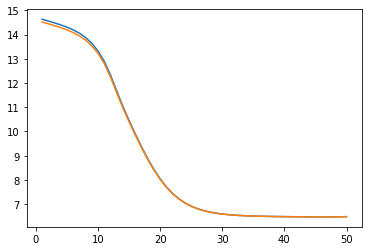

In [17]:

plt.plot(np.arange(1,nepochs+1),running_trainloss)
plt.plot(np.arange(1,nepochs+1),running_testloss)
#plt.xscale('log')
#plt.yscale('log')

#plt.ylim(10**(-5),10**(1))
#plt.xlim(1,1000)

plt.show()


In [18]:

running_trainloss_gd = torch.clone(running_trainloss)
running_testloss_gd = torch.clone(running_testloss)


In [19]:

# remove the squared mean

wdcov = np.copy(wdrec)
wtcov = np.copy(wtrec)
wocov = np.copy(worec)

#wdcov[3,:,:,:] = wdrec[3,:,:,:] - wmrec**2
for iL in range(L):
    wdcov[3,iL,:,:] = wdrec[3,iL,:,:] - wmrec[iL,:,:]**2*dim[iL]*dim[iL+1]

for iL in range(L-1):
    wtcov[1,iL,:,:] = wtrec[1,iL,:,:] - wmrec[iL,:,:]*wmrec[iL+1,:,:]*dim[iL+1]*np.sqrt(dim[iL]*dim[iL+2])

iwo = 0
for iL in np.arange(0,L-2):
    for jL in np.arange(0,iL+1):
        wocov[iwo,:,:] = worec[iwo,:,:] - wmrec[iL+2,:,:]*wmrec[jL,:,:]*np.sqrt(dim[iL+2]*dim[iL+3])*np.sqrt(dim[jL]*dim[jL+1])
        iwo = iwo + 1

eigrec = np.zeros((4*L,nepochs,num_models))
for epoch in range(nepochs):
    for inet in range(num_models):
        #eigrec[:,epoch,inet] = sm.eig_unique(L,np.reshape(wdrec[:,:,epoch,inet],(4,L)),np.reshape(wtrec[:,:,epoch,inet],(2,L-1)),np.squeeze(worec[:,epoch,inet]))
        eigrec[:,epoch,inet] = sm.eig_unique(L,np.reshape(wdcov[:,:,epoch,inet],(4,L)),np.reshape(wtcov[:,:,epoch,inet],(2,L-1)),np.squeeze(wocov[:,epoch,inet]))


In [20]:

iepoch = 0

print(np.squeeze(wmrec[:,iepoch,:]))

print('\n')

print(np.squeeze(wdrec[:,:,iepoch,:]))

print('\n')

print(np.squeeze(wdcov[:,:,iepoch,:]))

print('\n')

print(np.squeeze(wtrec[:,:,iepoch,:]))

print('\n')

print(np.squeeze(wtcov[:,:,iepoch,:]))

print('\n')

print(np.squeeze(worec[:,iepoch,:]))

print('\n')

print(np.squeeze(wocov[:,iepoch,:]))

print('\n')

print(np.squeeze(eigrec[:,iepoch,:]))




[-1.25397122e-04 -8.44904065e-05  9.89171982e-05 -1.10081208e-04
  8.45179749e-04  4.21798974e-05 -3.11578679e-04 -2.09521103e-03
  5.89705348e-05 -1.31143036e-02]


[[ 1.84738355e-07  2.79523943e-05  4.12064835e-05  5.64398261e-05
   1.13593281e-04  1.77161483e-04  4.29178684e-04  2.67659671e-04
   5.13578562e-04  1.29076896e-06]
 [-9.32368119e-08 -2.54729133e-05 -4.02969984e-05 -5.44557857e-05
  -4.60811703e-05 -1.76053696e-04 -4.18284710e-04 -4.22466545e-05
  -5.12756300e-04  1.42240406e-02]
 [ 1.19159110e-03  9.28367911e-04  1.20471783e-03  1.90340982e-03
   2.83148847e-03  5.48506677e-03  1.02840161e-02  1.26448437e-02
   1.17634789e-02  3.78898713e-05]
 [-1.15237150e-03 -9.13000820e-04 -1.18116578e-03 -1.87509918e-03
  -1.11317856e-03 -5.48172670e-03 -1.00522069e-02 -1.89548359e-03
  -1.17556074e-02  4.15699175e-01]]


[[ 1.84738355e-07  2.79523943e-05  4.12064835e-05  5.64398261e-05
   1.13593281e-04  1.77161483e-04  4.29178684e-04  2.67659671e-04
   5.13578562e-04  1.29076896e-

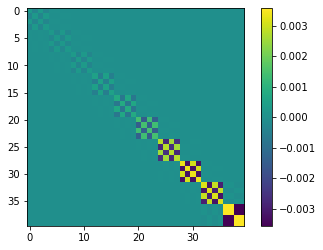

[[ 2.98013019e-04 -2.97967268e-04  2.97874899e-04 ...  6.12195665e-11
   6.12195665e-11  6.12195665e-11]
 [-2.97967268e-04  2.98013019e-04 -2.97920649e-04 ...  6.12195665e-11
   6.12195665e-11  6.12195665e-11]
 [ 2.97874899e-04 -2.97920649e-04  2.98013019e-04 ...  6.12195665e-11
   6.12195665e-11  6.12195665e-11]
 ...
 [ 6.12195665e-11  6.12195665e-11  6.12195665e-11 ...  3.56645068e-03
  -3.56580530e-03 -3.54686036e-03]
 [ 6.12195665e-11  6.12195665e-11  6.12195665e-11 ... -3.56580530e-03
   3.56645068e-03  3.54621498e-03]
 [ 6.12195665e-11  6.12195665e-11  6.12195665e-11 ... -3.54686036e-03
   3.54621498e-03  3.56645068e-03]]
[ 2.98013019e-04 -2.97967268e-04  2.97874899e-04 -2.97920649e-04
  3.03719842e-06  3.03719842e-06 -3.03719773e-06 -3.03719773e-06
 -9.04478298e-14 -9.04478298e-14 -9.04478298e-14 -9.04478298e-14
  4.71488362e-13  4.71488362e-13  4.71488362e-13  4.71488362e-13
 -7.00616739e-12 -7.00616739e-12 -7.00616739e-12 -7.00616739e-12
 -1.23003275e-13 -1.23003275e-13 -1.230

In [21]:

imodel = 0
dim_surrogate = 2

dim_small = np.zeros((L+1,))
for iL in range(L+1):
    dim_small[iL] = dim_surrogate
dim_small = dim_small.astype(int)

mat = sm.par2cov(L,dim_small,np.reshape(wdcov[:,:,iepoch,imodel],(4,L)),np.reshape(wtcov[:,:,iepoch,imodel],(2,L-1)),np.squeeze(wocov[:,iepoch,imodel]))

plt.imshow(mat)
plt.colorbar()
plt.show()

print(mat)

print(mat[0,:])



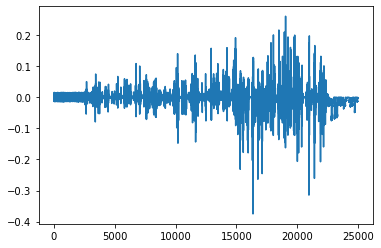

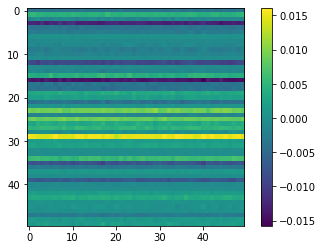

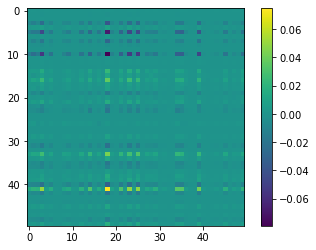

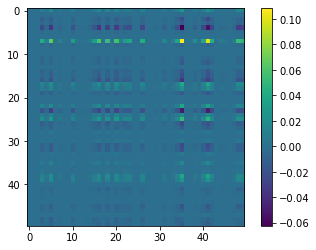

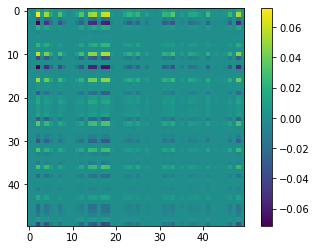

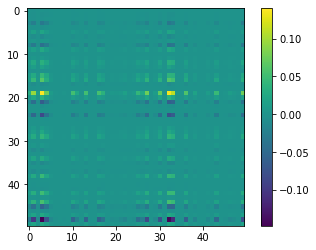

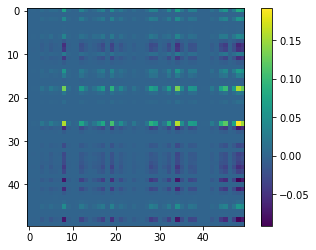

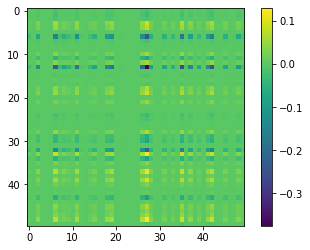

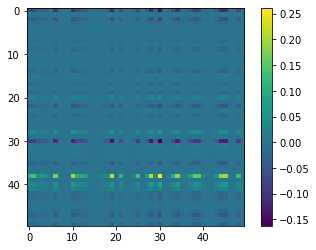

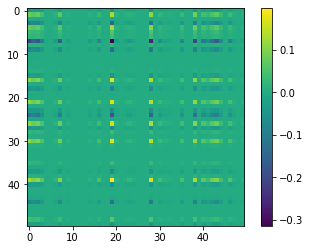

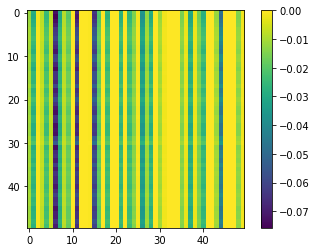

In [22]:

iepoch = 0
jnet = 0

plt.plot(grad_rec[:,iepoch,jnet])
plt.show()

for iL in range(L):
    plt.imshow(np.reshape(grad_rec[cpar[iL]:cpar[iL+1],iepoch,jnet],(dim[iL+1],dim[iL]),order='F'))
    #plt.clim((-1000,1000))
    plt.colorbar()
    plt.show()


In [ ]:
# compare two models

iepoch = 0

for iL in range(L):
    plt.scatter(np.abs(wdcov[:,iL,iepoch,0]),np.abs(wdcov[:,iL,iepoch,1]))

for iL in range(L-1):
    plt.scatter(np.abs(wtcov[:,iL,iepoch,0]),np.abs(wtcov[:,iL,iepoch,1]))

iwo = 0
for iL in np.arange(0,L-2):
    for jL in np.arange(0,iL+1):
        plt.scatter(np.abs(wocov[iwo,iepoch,0]),np.abs(wocov[iwo,iepoch,1]))
        iwo = iwo + 1

plt.plot([10**(-4), 10**7],[10**(-4), 10**7])
plt.xscale('log')
plt.yscale('log')
plt.show()


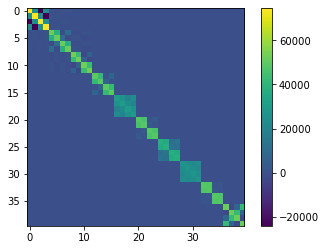

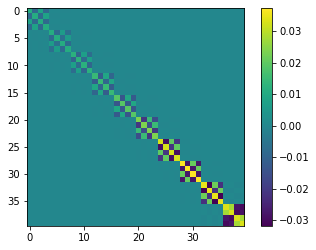

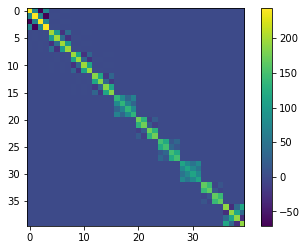

In [27]:
eps = 0.00001

evl, evc = np.linalg.eigh(mat+eps*np.eye(4*L))

imat = (evc * 1/evl) @ evc.T

smat = (evc * np.sqrt(evl)) @ evc.T

ismat = (evc * 1/np.sqrt(evl)) @ evc.T


plt.imshow(imat)
plt.colorbar()
plt.show()

plt.imshow(smat)
plt.colorbar()
plt.show()

plt.imshow(ismat)
plt.colorbar()
plt.show()



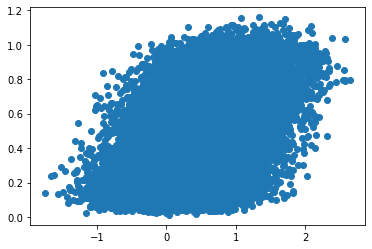

In [28]:

with torch.no_grad():
    outputs_train = net(inputs_train)


plt.scatter(inputs_train[:,0],outputs_train[:,0])
#plt.scatter(inputs_train[:,0],labels_train[:,0])
plt.show()



### Learning rate

In [114]:

lr = 0.00075
nepochs = 50

eps = 0.001

beta = 0.


### Reset

In [115]:

for inet in range(num_models):
    nets[inet].load_state_dict(nets0[inet].state_dict())
    

### Training, ensemble cov

In [116]:

rec_time = 1
nitera = int(nepochs/rec_time)

running_trainloss = torch.zeros( (nitera,num_models) )
running_testloss = torch.zeros( (nitera,num_models) )

wmrec = np.zeros((L,nepochs,num_models))

wdrec = np.zeros((4,L,nepochs,num_models))
wtrec = np.zeros((2,L-1,nepochs,num_models))
worec = np.zeros(((L-2)*(L-1)//2,nepochs,num_models))

wdcov = np.copy(wdrec)
wtcov = np.copy(wtrec)
wocov = np.copy(worec)

#itera = 0    

for epoch in range(nepochs):  # loop over the dataset multiple times

    for inet in range(num_models):
        
        # print statistics
        #if epoch % rec_time == rec_time-1:    # print every 'rec_time' mini-batches

        
        with torch.no_grad():

            outputs_train = nets[inet](inputs_train)
            running_trainloss[epoch,inet] = torch.norm(outputs_train-labels_train)**2 / num_train_data / 2

            outputs_test = nets[inet](inputs_test)
            running_testloss[epoch,inet] = torch.norm(outputs_test-labels_test)**2 / num_test_data / 2

        print(epoch + 1)
        #itera += 1

        # Compute the loss
        outputs_train = nets[inet](inputs_train)
        loss = torch.norm(outputs_train-labels_train)**2 / num_train_data / 2

        # Compute first-order gradients
        grads = torch.autograd.grad(loss, nets[inet].parameters(), create_graph=False)

        grad_vec_F = torch.cat([g.T.reshape(-1,1) for g in grads])
        grad_vec_C = torch.cat([g.view(-1) for g in grads])
        
        grad_np = grad_vec_F.numpy()
        
        wmrec[:,epoch,inet], wdrec[:,:,epoch,inet], wtrec[:,:,epoch,inet], worec[:,epoch,inet] = sm.grad2par_fast(L,dim,grad_np)

        wdcov[:,:,epoch,inet]=wdrec[:,:,epoch,inet]
        wtcov[:,:,epoch,inet]=wtrec[:,:,epoch,inet]
        wocov[:,epoch,inet]=worec[:,epoch,inet]
        
        for iL in range(L):
            wdcov[3,iL,:,:] = wdrec[3,iL,:,:] - wmrec[iL,:,:]**2*dim[iL]*dim[iL+1]

        for iL in range(L-1):
            wtcov[1,iL,:,:] = wtrec[1,iL,:,:] - wmrec[iL,:,:]*wmrec[iL+1,:,:]*dim[iL+1]*np.sqrt(dim[iL]*dim[iL+2])

        iwo = 0
        for iL in np.arange(0,L-2):
            for jL in np.arange(0,iL+1):
                wocov[iwo,:,:] = worec[iwo,:,:] - wmrec[iL+2,:,:]*wmrec[jL,:,:]*np.sqrt(dim[iL+2]*dim[iL+3])*np.sqrt(dim[jL]*dim[jL+1])
                iwo = iwo + 1
        
        wd = np.reshape(wdcov[:,:,epoch,inet],(4,L))
        wt = np.reshape(wtcov[:,:,epoch,inet],(2,L-1))
        wo = np.squeeze(wocov[:,epoch,inet])
        wdreg = np.copy(wd)
        
        evl = sm.eig_unique(L,wd,wt,wo)
        #if np.min(evl)<0:
        #    eps = -2*np.min(evl)
        #else:
        #    eps = 0 
        
        wdreg[0,:] = wdreg[0,:] + eps
        wd, wt, wo = sm.squareroot(L,wdreg,wt,wo)
        wd, wt, wo = sm.inverse(L,wd,wt,wo)
        
        #print(wd)
        #print(wt)
        #print(wo)
        #print(evl)
        
        grad_np = grad_np.reshape((num_parameters,))
        update_F = sm.matvec_fast(L,dim,wd,wt,wo,grad_np)
        update_C = np.copy(update_F)
        
        update_F = (1-beta)*update_F + beta*sm.par2mean(L,dim,np.squeeze(wmrec[:,epoch,inet]))
        
        for iL in range(L):
            upd = update_F[cpar[iL]:cpar[iL+1]].reshape((dim[iL+1],dim[iL]),order='F')
            update_C[cpar[iL]:cpar[iL+1]]=np.reshape(upd,(dim[iL+1]*dim[iL],),order='C')

        param_vec = torch.nn.utils.parameters_to_vector(nets[inet].parameters())
        torch.nn.utils.vector_to_parameters( param_vec - lr * torch.tensor(update_C).float() , nets[inet].parameters())    


print('Finished Training')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
Finished Training


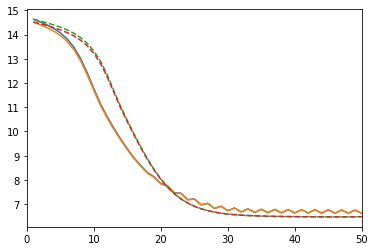

In [117]:

plt.plot(np.arange(1,nepochs+1),running_trainloss)
plt.plot(np.arange(1,nepochs+1),running_testloss)

plt.plot(np.arange(1,nepochs+1),running_trainloss_gd,linestyle='dashed')
plt.plot(np.arange(1,nepochs+1),running_testloss_gd,linestyle='dashed')

#plt.xscale('log')
#plt.yscale('log')

#plt.ylim(10**(-5),10**(1))
plt.xlim(0,50)

plt.show()


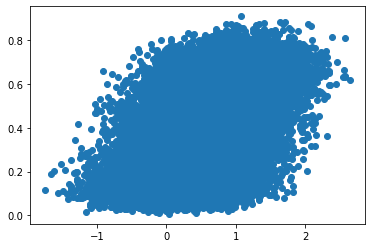

In [74]:

with torch.no_grad():
    outputs_train = net(inputs_train)


plt.scatter(inputs_train[:,0],outputs_train[:,0])
#plt.scatter(inputs_train[:,0],labels_train[:,0])
plt.show()


### Save experiment

In [ ]:

#PATH = './mlp_iGD.pt'
#torch.save({'do':d0, 'd1':d1, 'd':d, 'L':L, 'num_train_data':num_train_data, 'num_test_data':num_test_data, 'noise':noise, 'lr':lr, 'nepochs':nepochs, 'rec_time':rec_time, 'running_trainloss':running_trainloss, 'running_testloss':running_testloss, 'tol':tol}, PATH)

#PATH = './mlp_up_iGD.pt'
#torch.save({'do':d0, 'd1':d1, 'd':d, 'L':L, 'num_train_data':num_train_data, 'num_test_data':num_test_data, 'noise':noise, 'lr':lr, 'nepochs':nepochs, 'rec_time':rec_time, 'running_trainloss':running_trainloss, 'running_testloss':running_testloss, 'tol':tol}, PATH)

